In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')


# Function to split 2d space

In [4]:
#splitting the 2d space
#sample input split_2d_space(10, (0,0), (20,30))
def split_2d_space(n, bottom_left, top_right): 
    """
    Split the 2D space into n smaller 2D spaces.
    
    Parameters:
        n (int): The number of smaller spaces to split the 2D space into.
        
    Returns:
        List of tuples: Each tuple contains the coordinates of the corners of a smaller space.
    """
    # Define the corners of the 2D space
    #top_right = (50, 50)
    #bottom_left = (0, 0)
    
    # Calculate the number of rows and columns in the grid
    num_rows = int(np.sqrt(n))
    num_cols = n // num_rows
    
    # Calculate the width and height of each smaller space
    width = int((top_right[0] - bottom_left[0]) / num_cols)+1
    height = int((top_right[1] - bottom_left[1]) / num_rows)+1
    
    # Generate the coordinates of the corners of each smaller space
    smaller_spaces = []
    for i in range(num_rows):
        for j in range(num_cols):
            x1 = bottom_left[0] + j * width
            y1 = bottom_left[1] + i * height
            x2 = x1 + width
            if x2 > top_right[0]:
                x2 = top_right[0]
            y2 = y1 + height
            
            if y2 > top_right[1]:
                y2 = top_right[1]
       
            smaller_spaces.append(((x1, y1), (x2, y2)))
    
    return smaller_spaces



In [5]:
# Example usage:
num_spaces = 6
smaller_spaces = split_2d_space(num_spaces, (0,0), (100,100))
print(smaller_spaces)


[((0, 0), (34, 51)), ((34, 0), (68, 51)), ((68, 0), (100, 51)), ((0, 51), (34, 100)), ((34, 51), (68, 100)), ((68, 51), (100, 100))]


In [6]:
for i in smaller_spaces:
    print(i)

((0, 0), (34, 51))
((34, 0), (68, 51))
((68, 0), (100, 51))
((0, 51), (34, 100))
((34, 51), (68, 100))
((68, 51), (100, 100))


# Function to plot boxes

In [7]:
#plotting bounding boxes
import matplotlib.pyplot as plt

def plot_bounding_boxes(bounding_boxes, x_max, y_max, ev_points=None, optim_list=None):
    """
    Plot bounding boxes on a 2D plot.
    
    Parameters:
        bounding_boxes (list of tuples): List of tuples, where each tuple contains the coordinates
                                         of the bottom left and top right corners of a bounding box.
    """
    fig, ax = plt.subplots()
    
    for box in bounding_boxes:
        # Extract coordinates
        (x1, y1), (x2, y2) = box
        
        # Plot bounding box
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=None, edgecolor='r'))
    
    # Set plot limits
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    # Show plot
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.scatter(ev_points[:,0], ev_points[:,1], color = 'blue')
    #plt.scatter(optim_list[:,0], optim_list[:,1], color='red')
    plt.show()



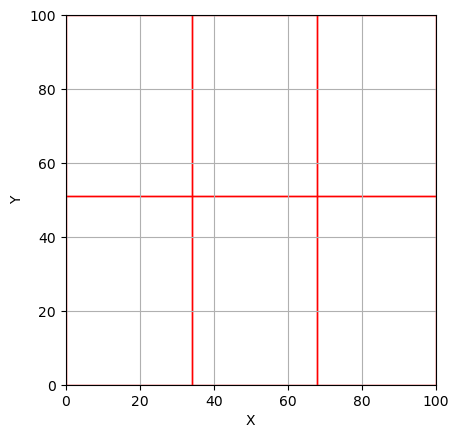

In [8]:
# Plot bounding boxes
plot_bounding_boxes(smaller_spaces ,100,100)


In [9]:
#generate random n 2d points 
def generate_random_points(num_points, x_range, y_range):
    x = np.random.uniform(x_range[0], x_range[1], num_points)
    y = np.random.uniform(y_range[0], y_range[1], num_points)
    return np.column_stack((x, y))

# Example usage:
num_points = 100
x_range = (0, 100)  # Example range for x coordinates
y_range = (0, 100)  # Example range for y coordinates

demand_points = generate_random_points(num_points, x_range, y_range)


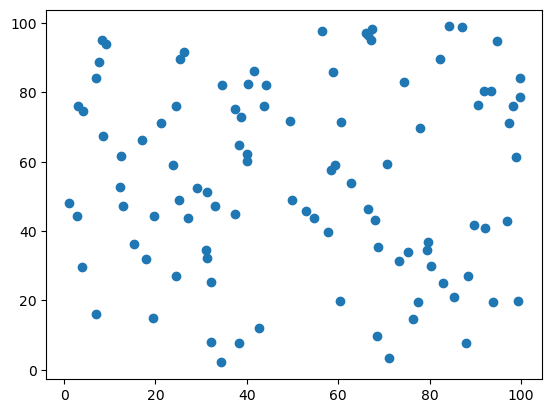

In [10]:
plt.scatter(demand_points[:,0],demand_points[:,1])

In [11]:
# assigining sub space to random points
def filter_points(points, subspace):
    """
    Filter points that belong to a specific sub-space.

    Parameters:
        points (list): List of tuples containing coordinates of random points.
        subspace (tuple): Tuple containing the coordinates of the corners of a sub-space.

    Returns:
        List of tuples: Filtered points that belong to the specified sub-space.
    """
    filtered_points = []
    for point in points:
        x, y = point
        x1, y1 = subspace[0]
        x2, y2 = subspace[1]
        if x1 <= x <= x2 and y1 <= y <= y2:
            filtered_points.append(point)
    return np.array(filtered_points)

In [12]:
trial1 = filter_points(demand_points, smaller_spaces[2])

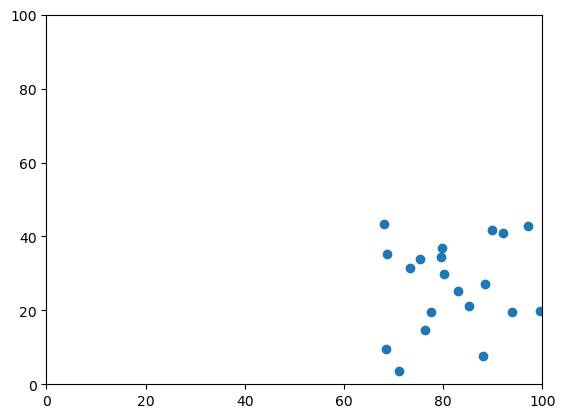

In [13]:
fig, ax = plt.subplots()
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.scatter(trial1[:,0],trial1[:,1])

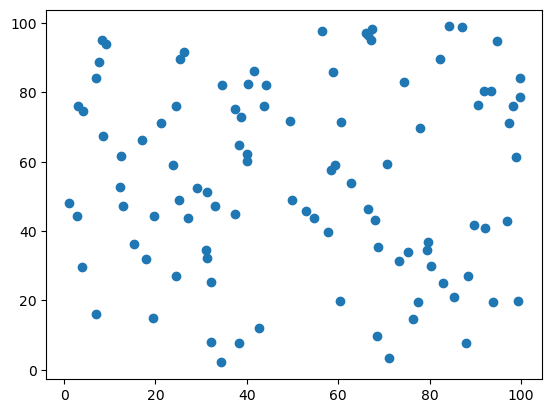

In [14]:
plt.scatter(demand_points[:,0],demand_points[:,1])

In [15]:
len(trial1)

20

In [16]:
11+18+19+13+27+12

100

# optimization

In [17]:
#fitness function, for each charging point
def fitness(charging_station_location, demand_points, sigma, m, Ee, Pe):
    total_cost = 0
    for demand_point in demand_points:
        # Calculate the Euclidean distance between charging station and demand point
        distance = np.linalg.norm(charging_station_location - demand_point)
            
        # Convert the distance to actual distance using the conversion factor sigma
        actual_distance = sigma * distance
            
        # Calculate the electricity and time-consuming costs for each demand point
        demand_point_cost = m * actual_distance * Ee * Pe
            
        # Accumulate the costs for all demand points
        total_cost += demand_point_cost
    
    return total_cost

In [18]:
#all code, tho it works on only one sub 2d space
def Optimization(demand_points, xMin, xMax, yMin, yMax):
    #parameter setting
    d = 2 #dimension
    #xMin, xMax  = 0, 100 #search space
    v_x_Min, v_x_Max = -0.2*(xMax - xMin), 0.2 * (xMax - xMin)
    v_y_Min, v_y_Max = -0.2*(yMax - yMin), 0.2 * (yMax - yMin)

    maxIt = 100
    ps = 300    #popn size, initialize 100 

    c1 =2
    c2=2

    w = 0.9 - ((0.9 - 0.4)/maxIt) * np.linspace(0, maxIt, maxIt)

    def limitV(V):
        for i in range(len(V)):
            if i==0:
                if V[i] > v_x_Max:
                    V[i] = v_x_Max
                if V[i] < v_x_Min:
                    V[i] = v_x_Min
            elif i==1:
                if V[i] > v_y_Max:
                    V[i] = v_y_Max
                if V[i] < v_y_Min:
                    V[i] = v_y_Min
        return V

    def limitX(X):
        for i in range(len(X)):
            if i==0:
                if X[i] > xMax:
                    X[i] = xMax
                if X[i] < xMin:
                    X[i] = xMin
            elif i==1:
                if X[i] > yMax:
                    X[i] = yMax
                if X[i] < yMin:
                    X[i] = yMin
        return X
    
    class Particle():
        def __init__(self, demand_points):
            self.position  = np.random.uniform(xMin, xMax, [ps, d])
            self.velocity = np.random.uniform(v_x_Min, v_x_Max, [ps, d])
            self.cost = np.zeros(ps)
            self.demand_points = demand_points
            self.sigma = 1.0  #conversion factor
            self.m = 10    #no of cars per day charge
            self.Ee = 0.2  #electricity
            self.Pe = 0.1  #charginga
            
            self.cost[:] = np.array([fitness(i, self.demand_points, self.sigma, self.m, self.Ee, self.Pe) for i in self.position])
            
            self.pbest = np.copy(self.position)
            self.pbest_cost = np.copy(self.cost)
            
            self.index = np.argmin(self.pbest_cost)
            
            self.gbest = self.pbest[self.index]
            self.gbest_cost = self.pbest_cost[self.index]
            
            self.BestCost = np.zeros(maxIt)
            
        
        def Evaluate(self):
            for it in range(maxIt):
                for i in range(ps):
                    
                    self.velocity[i] = (w[it]*self.velocity[i]
                                        + c1 * np.random.rand(d)*(self.pbest[i] - self.position[i])
                                        + c2 * np.random.rand(d)*(self.gbest - self.position[i]))
                    
                    self.velocity[i] = limitV(self.velocity[i])
                    old = self.position[i]
                    self.position[i] = self.position[i] + self.velocity[i]
                    new = self.position[i]
                    
                    if not np.array_equal(old, new):
                        print(it, ' something changed ',i)
                    self.position[i] = limitX(self.position[i])
                    self.cost[i] = fitness(self.position[i], self.demand_points, self.sigma, self.m, self.Ee, self.Pe)
                    
                    if self.cost[i] < self.pbest_cost[i]:
                        self.pbest[i] = self.position[i]
                        self.pbest_cost[i] = self.cost[i]
                        
                        if self.pbest_cost[i] < self.gbest_cost:
                            self.gbest = self.pbest[i]
                            self.gbest_cost = self.pbest_cost[i]
                    
                self.BestCost[it] = self.gbest_cost
                
                
        def plot_result(self):
            #plt.semilogy(self.BestCost)
            print('Best fitness value = ', self.gbest_cost)
            print('Best fitness x  = ', self.gbest)
        
    a = Particle(demand_points)
    #optim = a.gbest
    #pos = a.position
    a.Evaluate()
    #a.plot_result()
    return a.gbest, a.BestCost

In [19]:
smaller_spaces[2]

((68, 0), (100, 51))

In [20]:
x_min = smaller_spaces[2][0][0]
x_max = smaller_spaces[2][1][0]
y_min = smaller_spaces[2][0][1]
y_max = smaller_spaces[2][1][1]
x_min, x_max, y_min, y_max

(68, 100, 0, 51)

In [21]:
points = Optimization(filter_points(demand_points, smaller_spaces[2]), x_min, x_max, y_min, y_max)

In [22]:
points

(array([81.38521896, 28.08970861]),
 array([105.27918884,  72.71990653,  54.99015555,  54.39856486,
         54.34438655,  54.34438655,  54.34438655,  54.34438655,
         54.34438655,  54.34438655,  54.34438655,  54.34438655,
         54.34438655,  54.34438655,  54.34438655,  54.34438655,
         54.34438655,  54.34438655,  54.34438655,  54.34438655,
         54.34429938,  54.34429938,  54.34429938,  54.34429938,
         54.34429938,  54.34429938,  54.34425956,  54.34425956,
         54.34425956,  54.34425956,  54.34425956,  54.34425956,
         54.34425956,  54.34425956,  54.34425177,  54.34425177,
         54.34425177,  54.34425177,  54.34425177,  54.34425177,
         54.34425177,  54.34425177,  54.34425177,  54.34425177,
         54.34425177,  54.34425177,  54.34425161,  54.34425161,
         54.34425161,  54.34425101,  54.34425101,  54.34425101,
         54.344251  ,  54.3442507 ,  54.34424983,  54.34424983,
         54.34424983,  54.34424976,  54.34424976,  54.34424976,
    

In [27]:
points

(array([81.38521896, 28.08970861]),
 array([105.27918884,  72.71990653,  54.99015555,  54.39856486,
         54.34438655,  54.34438655,  54.34438655,  54.34438655,
         54.34438655,  54.34438655,  54.34438655,  54.34438655,
         54.34438655,  54.34438655,  54.34438655,  54.34438655,
         54.34438655,  54.34438655,  54.34438655,  54.34438655,
         54.34429938,  54.34429938,  54.34429938,  54.34429938,
         54.34429938,  54.34429938,  54.34425956,  54.34425956,
         54.34425956,  54.34425956,  54.34425956,  54.34425956,
         54.34425956,  54.34425956,  54.34425177,  54.34425177,
         54.34425177,  54.34425177,  54.34425177,  54.34425177,
         54.34425177,  54.34425177,  54.34425177,  54.34425177,
         54.34425177,  54.34425177,  54.34425161,  54.34425161,
         54.34425161,  54.34425101,  54.34425101,  54.34425101,
         54.344251  ,  54.3442507 ,  54.34424983,  54.34424983,
         54.34424983,  54.34424976,  54.34424976,  54.34424976,
    

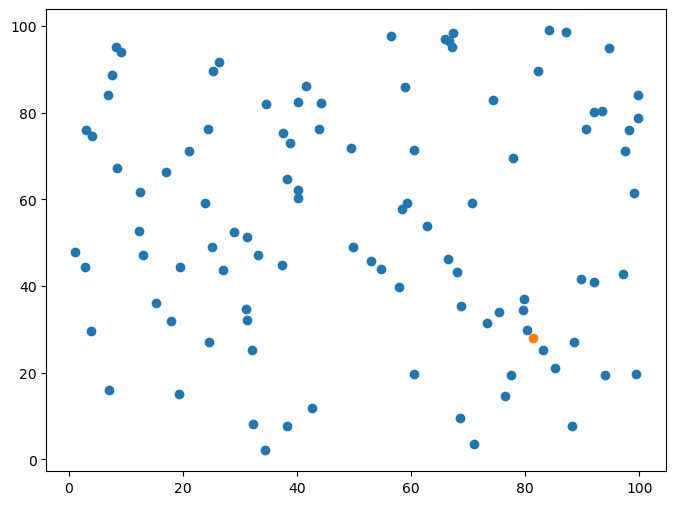

In [25]:
a, b = plt.subplots(figsize=(8,6))
plt.scatter(demand_points[:,0],demand_points[:,1])
plt.scatter(points[0][0],points[0][1])

# function to optimize each subspace

In [28]:
def sub_space_optimization(demand_points, sub_space_list):
    optimum_locations = []
    for i in range(len(sub_space_list)):
        x_min = sub_space_list[i][0][0]
        x_max = sub_space_list[i][1][0]
        y_min = sub_space_list[i][0][1]
        y_max = sub_space_list[i][1][1]
        
        points, loss_plot = Optimization(filter_points(demand_points, sub_space_list[i]), x_min, x_max, y_min, y_max)
        
        optimum_locations.append(points)
    return np.array(optimum_locations), loss_plot

In [29]:
to_plot, lp = sub_space_optimization(demand_points, smaller_spaces)

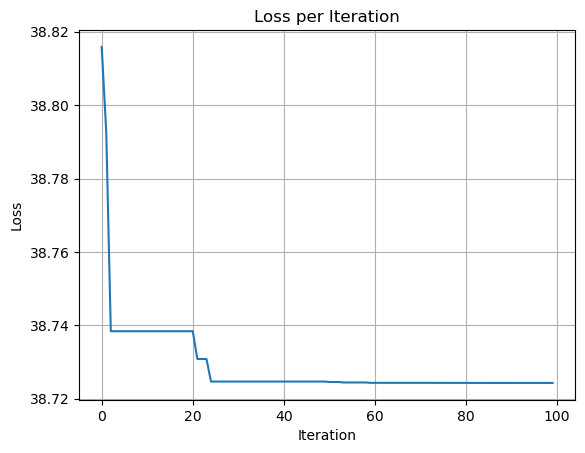

In [30]:
plt.plot(lp)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss per Iteration')
plt.grid(True)
plt.show()

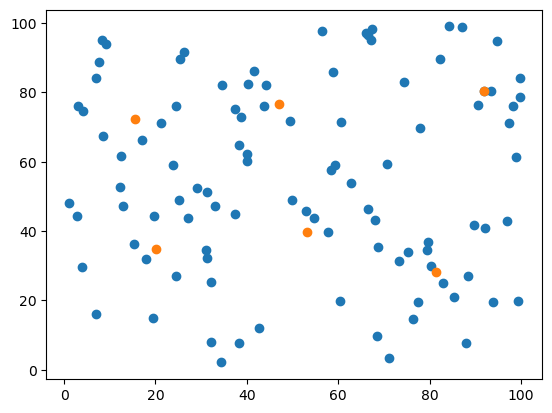

In [31]:
plt.scatter(demand_points[:,0],demand_points[:,1])
plt.scatter(to_plot[:,0],to_plot[:,1])

# Overall final function

In [32]:
#final one

def get_charging_locations(number_of_evs, charging_stations, max_x_location, max_y_location):
    x_range = max_x_location
    y_range = max_y_location
    num_points = number_of_evs
    
    #generating vehicles at different locations
    demand_points = generate_random_points(num_points, (0,x_range), (0,y_range))
    
    #split space
    num_spaces = charging_stations
    smaller_spaces = split_2d_space(num_spaces, (0,0), (x_range,y_range))
    
    to_plot ,loss_plot= sub_space_optimization(demand_points, smaller_spaces)
    
    
    #plotting
    fig, ax = plt.subplots(figsize=(8,6))
    
    for box in smaller_spaces:
        # Extract coordinates
        (x1, y1), (x2, y2) = box
        
        # Plot bounding box
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=None, edgecolor='r'))
    
    # Set plot limits
    ax.set_xlim(0, x_range)
    ax.set_ylim(0, y_range)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    # Show plot
    plt.grid(True)
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(demand_points[:,0],demand_points[:,1], color='blue')
    plt.scatter(to_plot[:,0],to_plot[:,1], color='red')
    plt.savefig('points.png')

    plt.show()
    
    return to_plot, demand_points, loss_plot

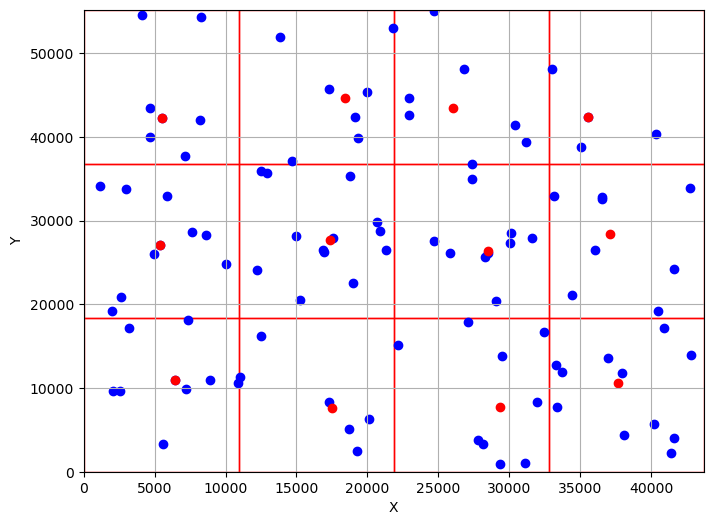

In [40]:
charging_points, evs , loss= get_charging_locations(100, 12, 43706,55192)

In [35]:
x_origin = 433617
y_origin = 10001823

In [36]:
charging_points_cpy = charging_points
evs_cpy = evs

charging_points_cpy[:, 0] += x_origin
charging_points_cpy[:, 1] += y_origin

evs_cpy[:, 0] += x_origin
evs_cpy[:, 1] += y_origin

In [37]:
import os
from shapely.geometry import Point
from geopandas import GeoDataFrame

# List of points in UTM coordinates (UTM WGS84 Zone 36S)


# Create empty GeoDataFrame
gdf = GeoDataFrame(columns=['geometry'])

# Create Point objects from the points and add them to GeoDataFrame
for point in charging_points_cpy:
    geometry = Point(point[0], point[1])
    gdf = gdf.append({'geometry': geometry}, ignore_index=True)

# Define projection for UTM WGS84 Zone 36S using EPSG code
gdf.crs = "EPSG:32736"  # EPSG code for UTM Zone 36S

# Directory to save shapefile
output_dir = "output"

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save as shapefile
gdf.to_file(os.path.join(output_dir, 'charging_points_20.shp'), driver='ESRI Shapefile', shape_type='point')


In [38]:
# Create Point objects from the points and add them to GeoDataFrame
for point in evs_cpy:
    geometry = Point(point[0], point[1])
    gdf = gdf.append({'geometry': geometry}, ignore_index=True)

# Define projection for UTM WGS84 Zone 36S using EPSG code
gdf.crs = "EPSG:32736"  # EPSG code for UTM Zone 36S

# Directory to save shapefile
output_dir = "output"

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save as shapefile
gdf.to_file(os.path.join(output_dir, 'evs_20.shp'), driver='ESRI Shapefile', shape_type='point')


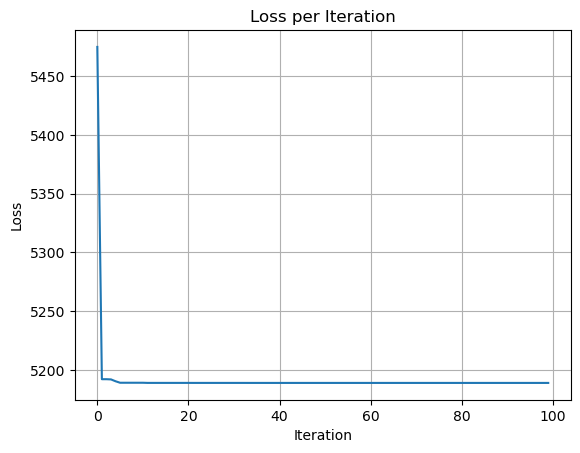

In [39]:
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss per Iteration')
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()